In [1]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import shgo
from scipy.optimize import NonlinearConstraint as NLC
from scipy.optimize import LinearConstraint as LC

import numpy as np
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import cvxpy as cp

from RKHS import Gram

In [2]:
# The differentiable kernel function with parameters c,l not filled.
def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return c * np.exp(-(np.linalg.norm(x1-x2+small_sig,axis = -1)**2) / l)

def GPMI(x,c,l,var_0):# The mutual information for a GP.
    x = x.reshape(-1,2)
    KA = k(x[:,np.newaxis,:],x,c,l)
    if var_0>0:
        return 1/2*np.log(np.linalg.det(np.eye(len(KA))+KA/var_0))
    else:
        return 1/2*np.log(np.linalg.det(KA))

In [20]:
def rand_search(x0,R,objective,T):
    best_xs = []
    best_val = -np.inf
    
    for _ in range(50000):

        xs = [x0]
        for i in range(T-1):

            cand_x = 0
            while True:
                r = step_size

                theta = np.random.rand()*2*np.pi

                cand_x = xs[-1]+r*np.array([np.cos(theta),np.sin(theta)])

                if np.linalg.norm(cand_x-x0)<=R:
                    break

            xs.append(cand_x)

        xs = np.array(xs)
        val = objective(xs)

        if val>best_val:
            best_xs = xs
            best_val=val
            
    return best_xs,best_val

In [21]:
def h(r,c,l):
    return c * np.exp(-(r**2) / l**2)

In [22]:

T = 7

c = 1
l = 1
var_0 = 0.01
objective = lambda z: GPMI(z,c=c,l=l,var_0=var_0)


search_region_center = np.array([0,0])
step_size = 1

In [23]:
kernel = partial(k,c=c,l=l)

# Random search I

**No** bounded search region constraint.

Fix $||x_t-x_{t-1}||=D$, and search using random direction.

$$
    x_t\gets x_{t-1} + D * \text{ random unit vector}
$$


In [24]:
rand,_ = rand_search(search_region_center,\
                         np.inf,objective,T)

In [25]:
sols = {'Random Search': rand,
        'Straight Line': np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size
       }


# Solve for the upper bound


$$
    \max_S \log(\det(I+\sigma^{-2}S))\\
    S_{ii}=c\\
    S_{i,i+1}=S_{i+1,i}\geq d\\
    S\succeq 0\\
    (\text{Without admissibility constraints})
$$

In [26]:
n = T
c = 1
var = var_0


d = h(step_size,c=c,l=l)

I = np.eye(n)

S = cp.Variable((n,n),symmetric=True)

constraints = [cp.diag(S)==c]

constraints+=[S[i,i+1]>=d for i in range(0,n-1)]

constraints+=[S>>0]

prob = cp.Problem(cp.Maximize(1/2*cp.log_det(I+ S/var)),constraints)

upper_bound = prob.solve()

# Compare the random search value and the upper bound

In [27]:
upper_bound

15.725918264309918

In [28]:
objective(sols['Random Search']) # Mutual information achieved by the random search

1.5714464697960821e+01

In [29]:
upper_bound-(objective(sols['Random Search'])) 

1.1453566349096889e-02

In [30]:
(upper_bound-(objective(sols['Random Search'])))/np.abs(upper_bound) # The 'competitive ratio'

7.283241688398469e-04

In [31]:
S.value

array([[0.9999994 , 0.36787981, 0.13401489, 0.0488275 , 0.01776215,
        0.00641178, 0.00228413],
       [0.36787981, 1.00000013, 0.36787983, 0.13400823, 0.04881001,
        0.01775389, 0.00643907],
       [0.13401489, 0.36787983, 0.99999992, 0.36787979, 0.13401547,
        0.04884005, 0.01780577],
       [0.0488275 , 0.13400823, 0.36787979, 0.99999997, 0.36787977,
        0.13403017, 0.04885486],
       [0.01776215, 0.04881001, 0.13401547, 0.36787977, 0.99999931,
        0.3678795 , 0.13401632],
       [0.00641178, 0.01775389, 0.04884005, 0.13403017, 0.3678795 ,
        1.0000003 , 0.3678793 ],
       [0.00228413, 0.00643907, 0.01780577, 0.04885486, 0.13401632,
        0.3678793 , 1.0000003 ]])

In [32]:
Gram(kernel,sols['Random Search'])

array([[1.00000000e+00, 3.67879441e-01, 1.93899636e-01, 7.50634328e-03,
        3.97492674e-04, 6.44498167e-07, 2.78917285e-08],
       [3.67879441e-01, 1.00000000e+00, 3.67879441e-01, 9.13260744e-02,
        3.21923421e-03, 2.29556848e-05, 3.04342449e-07],
       [1.93899636e-01, 3.67879441e-01, 1.00000000e+00, 3.67879441e-01,
        9.57633295e-02, 1.96270454e-03, 1.57263697e-04],
       [7.50634329e-03, 9.13260744e-02, 3.67879441e-01, 1.00000000e+00,
        3.67879441e-01, 4.90717645e-02, 2.37778787e-03],
       [3.97492674e-04, 3.21923422e-03, 9.57633296e-02, 3.67879441e-01,
        1.00000000e+00, 3.67879441e-01, 1.09971461e-01],
       [6.44498168e-07, 2.29556848e-05, 1.96270454e-03, 4.90717646e-02,
        3.67879441e-01, 1.00000000e+00, 3.67879441e-01],
       [2.78917285e-08, 3.04342450e-07, 1.57263698e-04, 2.37778788e-03,
        1.09971461e-01, 3.67879441e-01, 1.00000000e+00]])

In [117]:
S.value-Gram(kernel,sols['Random Search'])

array([[-6.01916709e-07,  3.67277513e-07,  4.66158701e-02,
         4.45789321e-02,  1.76539640e-02,  6.41076525e-03,
         2.28412708e-03],
       [ 3.67484168e-07,  1.29211274e-07,  3.86938520e-07,
         6.55941163e-03,  4.33314301e-02,  1.74064020e-02,
         6.43845421e-03],
       [ 4.66158702e-02,  3.87007626e-07, -8.19363816e-08,
         3.49895094e-07,  1.73969063e-02,  4.25333471e-02,
         1.77403724e-02],
       [ 4.45789321e-02,  6.55941172e-03,  3.50093375e-07,
        -2.57991901e-08,  3.29528353e-07, -1.12130721e-02,
         4.48562830e-02],
       [ 1.76539640e-02,  4.33314301e-02,  1.73969064e-02,
         3.29606116e-07, -6.92985199e-07,  6.08856539e-08,
         7.19259354e-02],
       [ 6.41076525e-03,  1.74064020e-02,  4.25333471e-02,
        -1.12130720e-02,  6.10758153e-08,  3.02156622e-07,
        -1.44144992e-07],
       [ 2.28412708e-03,  6.43845421e-03,  1.77403724e-02,
         4.48562830e-02,  7.19259355e-02, -1.43993054e-07,
         2.9727723

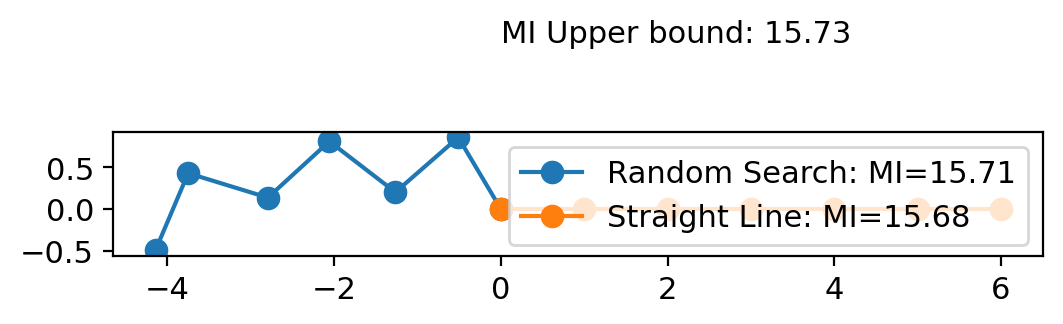

In [33]:

plt.rc('font',size=11)
plt.figure(dpi=200)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15,label="{}: MI={:.2f}".format(key,objective(val)))
    
    plt.gca().set_aspect('equal')

plt.text(0.,2.,'MI Upper bound: {:.2f}'.format(upper_bound))
# circ = plt.Circle(search_region_center,search_region_radius,label='Search Region Boundary',fill=False)
# plt.gca().add_patch(circ)
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.legend()
plt.show()

# Random search II

Adding bounded search region constraint.

Fix $||x_t-x_{t-1}||=D$, and search using random direction.

$$
    \hat{x}_t\gets x_{t-1} + D * \text{ random unit vector}
$$

If $\hat{x}_t$ is outside the search region, pick a new random unit vector and try again, until a feasible $\hat{x}_t$ is found. Then set $x_t\gets \hat{x}_t$.


In [56]:
search_region_radius = 1

In [57]:
rand,_ = rand_search(search_region_center,\
                         search_region_radius,objective,T)

In [58]:
sols = {'Random Search': rand,
        'Straight Line': np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size
       }


# Solve for the upper bound under the bounded region constraint
Given reference points $a_{1:N}$, inducing $A = [k(a_i,a_j)]$.

The ultimate problem we attempt to solve is,

$$
		\max_{x_1,x_2,...,x_{T}} F(x_{1:T})\\
        ~||x_{t+1}-x_t||\leq D,~\forall t=1,...,T-1\\
		~ ||x_t-a_k||\leq R_{t,k},~\forall 1\leq t \leq T,~1\leq k\leq N
$$

where $R_{t,k}$ are pre-specified distance bounds to the reference points. 

The convex relaxation of the above we consider hereafter is
$$
    \max_{\Sigma,B}~\log\det(I+\Sigma/\sigma^2)\\
		s.t.~M=\begin{bmatrix}
    \Sigma & B\\
B^\top & A
\end{bmatrix}\succ 0\\
~\Sigma_{ii}=c,\forall i=1,2,...,T\\
~\Sigma_{i,i+1}\geq d,\forall i=1,...,T-1\\
~B_{ik}\geq b_{ik}=h(R_{i,k}),\forall i,k\\
(\text{Without admissibility constraints})
$$

Very often we want to impose the constraint that the initial location $x_1$ is fixed, this can be achieve by specifying the desired initial location as the value of $a_1$ and impose $||x_1-a_1||\leq 0$, or $b_{11} = h(0)$.

The optimal value of the convex relaxation is an upper bound on the ultimate problem, which could be loose.


In [59]:
ref = np.array([[0,0]]) # A single point reference set.
R = np.array([[search_region_radius]])
A = Gram(kernel,ref)

N = len(A)


b = np.ones((T,N))*h(R,c=c,l=l)
b[0,0] = h(0,c=c,l=l) # Initial location constraint.

In [60]:
# Define and solve the problem
B = cp.Variable((T,N))

S = cp.Variable((T,T),symmetric=True)

M = cp.vstack([cp.hstack([S,B]),
               cp.hstack([B.T,A])])


constraints = [M>>0]


constraints += [cp.diag(S)==c]

constraints += [S[i,i+1]>=d for i in range(0,T-2)]

constraints += [B>=b]



prob = cp.Problem(cp.Maximize(1/2*cp.log_det(np.eye(T)+ S/var)),constraints)

upper_bound = prob.solve()

In [61]:
upper_bound

15.578051640072232

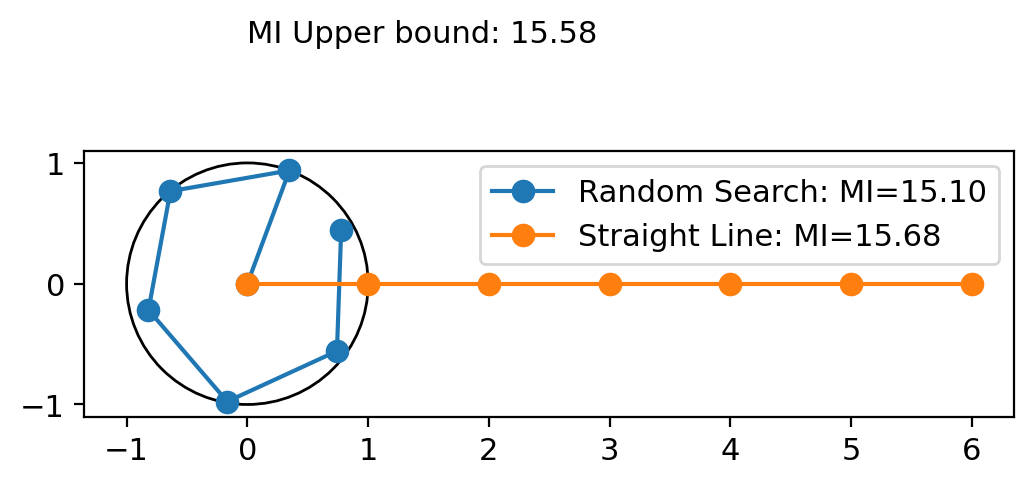

In [62]:

plt.rc('font',size=11)
plt.figure(dpi=200)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15,label="{}: MI={:.2f}".format(key,objective(val)))
    
    plt.gca().set_aspect('equal')

circ = plt.Circle(search_region_center,search_region_radius,fill=False)
plt.gca().add_patch(circ)
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.text(0.,2.,'MI Upper bound: {:.2f}'.format(upper_bound))
plt.legend()
plt.show()